In [ ]:
import os
import random
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from IPython.display import Image
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Conv2D,Activation,MaxPool2D,BatchNormalization,Flatten
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Sequential
# from tensorflow.keras.applications.MobileNetV2 import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model

In [ ]:
FAST_RUN = False
IMAGE_WIDTH=224
IMAGE_HEIGHT=224
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [ ]:
                                                         # I trained it on Google Colab, so it's of no use in Local drive.
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
csv_path='/content/drive/MyDrive/Data_challenge/train.csv'
data = pd.read_csv(csv_path)


In [ ]:
data.head()

,images,labels
0,AE00474_105028_00_4_3_2001.jpg,0
1,AE00305_043057_00_2_4_2001.jpg,1
2,AE00191_071651_00_2_2_2001.jpg,1
3,AE00191_103659_00_2_1_2001.jpg,1
4,AE00227_204647_00_3_4_2001.jpg,1


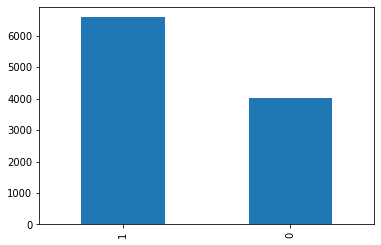

In [ ]:
data['labels'].value_counts().plot.bar()

0


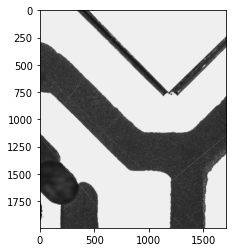

In [ ]:
image = load_img(r"/content/drive/MyDrive/Data_challenge/x_train/"+data['images'][4000])
plt.imshow(image)
print(data['labels'][4000])

In [ ]:
base_model=MobileNetV2(weights='imagenet',include_top=False)  #imports the mobilenet model and discards the last 1000 neuron layer.

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='ReLU')(x)                          #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='ReLU')(x)                          #dense layer 2
x=Dense(512,activation='ReLU')(x)                           #dense layer 3
preds=Dense(2,activation='softmax')(x)                      #final layer with softmax activation

In [ ]:
model=Model(inputs=base_model.input,outputs=preds)

In [ ]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy']) 

In [ ]:
for layer in model.layers[:20]:
    layer.trainable=False
for layer in model.layers[20:]:
    layer.trainable=True

In [ ]:
l=data["labels"]
data["labels"] = data["labels"].replace({0: 'Bad', 1: 'Good'}) 


In [ ]:
train_df, validate_df = train_test_split(data, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

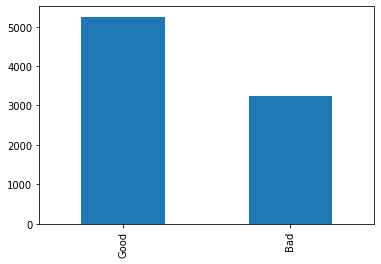

In [ ]:
train_df['labels'].value_counts().plot.bar()

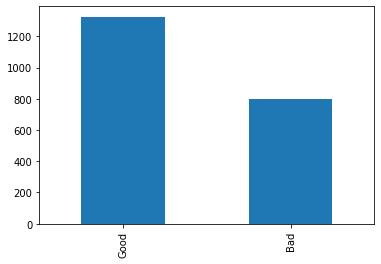

In [ ]:
validate_df['labels'].value_counts().plot.bar()

In [ ]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    r"/content/drive/MyDrive/Data_challenge/x_train/", 
    x_col='images',
    y_col='labels',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 8487 validated image filenames belonging to 2 classes.


In [ ]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    r"/content/drive/MyDrive/Data_challenge/x_train/", 
    x_col='images',
    y_col='labels',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)    

Found 2122 validated image filenames belonging to 2 classes.


In [ ]:
from sklearn.utils import class_weight


In [ ]:
from keras.callbacks import ModelCheckpoint
filepath = "/content/drive/MyDrive/Data_challenge/models/new-model-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, mode='max')


epochs=50
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    # class_weight=class_weights,
    callbacks=checkpoint
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/50
565/565 [==============================] - ETA: 0s - loss: 0.4052 - accuracy: 0.8915
Epoch 00001: saving model to /content/drive/MyDrive/Data_challenge/models/new-model-01-0.37.hdf5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


565/565 [==============================] - 2110s 4s/step - loss: 0.4052 - accuracy: 0.8915 - val_loss: 9.2279 - val_accuracy: 0.3749
Epoch 2/50
565/565 [==============================] - ETA: 0s - loss: 0.2290 - accuracy: 0.9521
Epoch 00002: saving model to /content/drive/MyDrive/Data_challenge/models/new-model-02-0.84.hdf5
565/565 [==============================] - 1737s 3s/step - loss: 0.2290 - accuracy: 0.9521 - val_loss: 0.8332 - val_accuracy: 0.8383
Epoch 3/50
499/565 [=========================>....] - ETA: 3:12 - loss: 0.1505 - accuracy: 0.9755

KeyboardInterrupt: ignored

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [ ]:
import cv2
img = cv2.imread(r'/content/drive/MyDrive/Data_challenge/x_test/AE00008_080949_00_2_2_2001.jpg')
img = img[...,::-1]                                                                 #give right image or else it will show error
model.predict(img[None,...], batch_size=None, verbose=2, steps=1)

1/1 - 4s - 4s/epoch - 4s/step


array([[1.0000000e+00, 1.2904581e-30]], dtype=float32)

In [ ]:
csv_path2='/content/drive/MyDrive/Data_challenge/test.csv'
data2 = pd.read_csv(csv_path2)
data2=data2
nb_samples = data2.shape[0]
print(nb_samples)

1989


In [ ]:
test_gen = ImageDataGenerator(rescale=1./255)
batch_size=15
test_generator = test_gen.flow_from_dataframe(
    data2, 
    r"/content/drive/MyDrive/Data_challenge/x_test/", 
    x_col='images',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 1988 validated image filenames.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 1 invalid image filename(s) in x_col="images". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [ ]:
predict = model.predict(test_generator, steps=np.ceil(nb_samples/batch_size))

In [ ]:
import sklearn
d = np.argmax(predict, axis=-1)

missing_image_name = 'AE00072_145326_00_1_2_2001.jpg'
print(data2[data2.images == missing_image_name])
data2.drop(data2.loc[data2.images == missing_image_name].index, inplace=True)
print(data2[data2.images == missing_image_name])



                             images  labels
922  AE00072_145326_00_1_2_2001.jpg       0
Empty DataFrame
Columns: [images, labels]
Index: []


In [ ]:
# d = np.argmax(predict, axis=-1)

def valeo_metric(dataframe_y_true, dataframe_y_pred):

    tn, fp, fn, tp = sklearn.metrics.confusion_matrix(dataframe_y_true, dataframe_y_pred).ravel()

    lambda_ = 100
    score = 1 / len(dataframe_y_true) * (fn + lambda_ * fp)
    return score
print(round(valeo_metric(data2['labels'], d),3))
tn, fp, fn, tp = sklearn.metrics.confusion_matrix(data2['labels'], d).ravel()
print(round((tn+tp)/(tn+fp+fn+tp) *100,3))
print(sklearn.metrics.confusion_matrix(data2['labels'], d))
# print(tp,tn)

0.306
99.296
[[ 772    6]
 [   8 1202]]


In [ ]:
data2['labels'].value_counts()

1    1210
0     778
Name: labels, dtype: int64

In [ ]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
data2['labels'] = data2['labels'].replace(label_map)
# print(data2['labels'])
 pandas.DataFrame(data=None, index=None

In [ ]:
data2['labels'].value_counts().plot.bar()

In [ ]:
sample_test = data2.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['images']
    category = row['labels']
    img = load_img(r"/content/drive/MyDrive/Data_challenge/x_test/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + (' ') + 'Result-' + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()